In [2]:
import pandas as pd
import numpy as np
from pandas import read_excel
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots
import os
#Author: Vatsala

In [3]:
#import fbprophet
#fbprophet.__version__

In [4]:
#import utils

In [5]:
plot_file_path ="../prophetForecastPlots/Plot"
plot_data_path ="../plotData/"

#### Specify Plot ID

In [6]:
plotId = "1"

#### Create directory for storing facebook prophet forecasts

In [7]:
# define the name of the directory to be created for the png outputs

path_image = plot_file_path+str(plotId)

try:
    if not os.path.exists(path_image):     
         os.mkdir(path_image)
except OSError:
    print ("Creation of the directory %s failed" % path_image)
else:
    print ("Successfully created the directory %s " % path_image)

Successfully created the directory ../prophetForecastPlots/Plot1 


In [8]:
#****** Running Forecast for Plot 1 *******  Note: Data has been QC-ed

#read Plot 1 data
data = read_excel('../plotData/plotData_1.xlsx', sheet_name='Sheet1', index_col=13, parse_dates=[13])    

In [9]:
print(data.head(10))
data.dtypes

                     QC  Plot_ID  DailyRep treatment       Date   pv      ghg  \
DateTime                                                                        
2019-03-26 17:26:00   0        1         4        F0 2019-03-26  ***  N2O_dry   
2019-03-26 21:49:00   0        1         5        F0 2019-03-26  ***  N2O_dry   
2019-03-27 06:28:00   0        1         1        F0 2019-03-27  ***  N2O_dry   
2019-03-28 20:34:00   0        1         2        F0 2019-03-28    *  N2O_dry   
2019-03-30 02:43:00   0        1         0        F0 2019-03-30  ***  N2O_dry   
2019-03-30 15:27:00   0        1         2        F0 2019-03-30  ***  N2O_dry   
2019-03-30 19:51:00   0        1         3        F0 2019-03-30   **  N2O_dry   
2019-03-31 00:17:00   0        1         0        F0 2019-03-31  ***  N2O_dry   
2019-03-31 04:43:00   0        1         1        F0 2019-03-31  ***  N2O_dry   
2019-03-31 13:32:00   0        1         3        F0 2019-03-31  ***  N2O_dry   

                    unit   

QC                     int64
Plot_ID                int64
DailyRep               int64
treatment             object
Date          datetime64[ns]
pv                    object
ghg                   object
unit                  object
flux                 float64
r2                   float64
nrmse                float64
podpu                float64
epoch_time            object
dtype: object

In [10]:
#This dataframe will be used for running in the Prophet model
#Extract only datetime and flux from the series

dataframe = DataFrame()
dataframe['Flux']  = data['flux']
dataframe['ghg']   = data['ghg']
dataframe

,Flux,ghg
DateTime,,
2019-03-26 17:26:00,-144.0262,N2O_dry
2019-03-26 21:49:00,-102.3469,N2O_dry
2019-03-27 06:28:00,-93.0909,N2O_dry
2019-03-28 20:34:00,63.8219,N2O_dry
2019-03-30 02:43:00,-157.9453,N2O_dry
...,...,...
2019-06-29 04:46:00,930.5471,CO2_dry
2019-06-29 13:22:00,412.6364,CO2_dry
2019-06-29 17:41:00,540.0715,CO2_dry


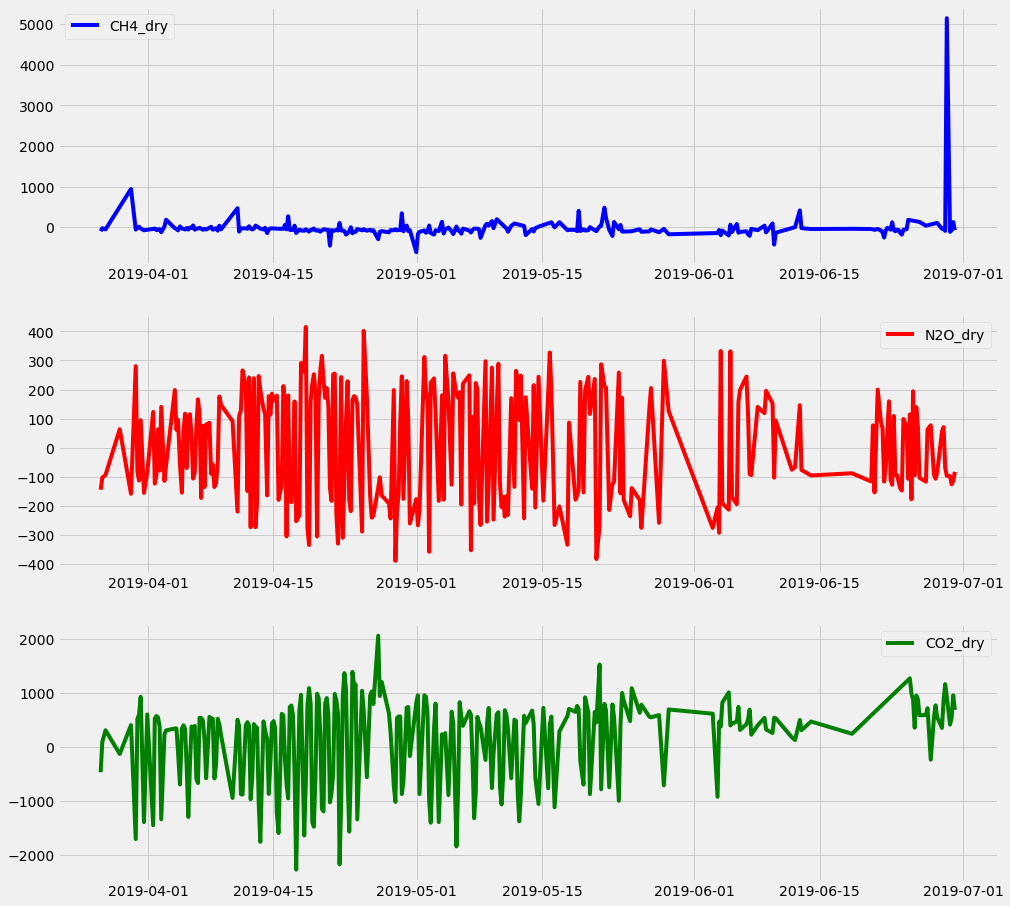

In [11]:
#Plot the data  - use dataframe 
#dataframe.set_index('DateTime').plot(style='--', figsize=(15,5), title='Flux Data')   #USE when index has not beem set when loading the data file

#dataframe.plot(style='-', figsize=(15,5), title='Flux Data')
#plt.show()

# Plot by each different gas

fig, axs = plt.subplots(3, figsize=(15,15))

df_CH4dry = dataframe[dataframe['ghg'] == 'CH4_dry']

df_N2Odry = dataframe[dataframe['ghg'] == 'N2O_dry']

df_CO2dry = dataframe[dataframe['ghg'] == 'CO2_dry']

axs[0].plot(df_CH4dry['Flux'], color='blue')
axs[1].plot(df_N2Odry['Flux'], color='red')
axs[2].plot(df_CO2dry['Flux'], color='green')

axs[0].legend(['CH4_dry'])
axs[1].legend(['N2O_dry'])
axs[2].legend(['CO2_dry'])

plt.show()

### Feature Engineering

In [12]:
#create some time series features to see how the trends are impacted by day of week, hour, time of year, etc.
#Feature Engineering  - feature used to visualise the data
def create_features(df, label=None):
    '''Create time series features from date time index'''
    df = df.copy()
    df['date']        = df.index #df['DateTime']  #.index
    df['hour']        = df['date'].dt.hour
    df['dayofmonth']  = df['date'].dt.day
    df['month']       = df['date'].dt.month
    df['year']        = df['date'].dt.year
    df['weekofyear']  = df['date'].dt.weekofyear
    df['dayofweek']   = df['date'].dt.dayofweek
    df['dayname']     = df['date'].dt.day_name() 
   
    X = df[['year', 'month', 'dayofmonth', 'weekofyear', 'hour', 'dayofweek', 'dayname']]  #features should be a matrix
    
    if label:
        y = df[label]   #target
        return X,y
    return X

In [13]:
X, y = create_features(dataframe, 'Flux')    #the target is the flux in this case; the features = X (as shown above)
features_target = pd.concat([X, y], axis=1)  #concatenate the features and the target
features_target.head()



,year,month,dayofmonth,weekofyear,hour,dayofweek,dayname,Flux
DateTime,,,,,,,,
2019-03-26 17:26:00,2019,3,26,13,17,1,Tuesday,-144.0262
2019-03-26 21:49:00,2019,3,26,13,21,1,Tuesday,-102.3469
2019-03-27 06:28:00,2019,3,27,13,6,2,Wednesday,-93.0909
2019-03-28 20:34:00,2019,3,28,13,20,3,Thursday,63.8219
2019-03-30 02:43:00,2019,3,30,13,2,5,Saturday,-157.9453


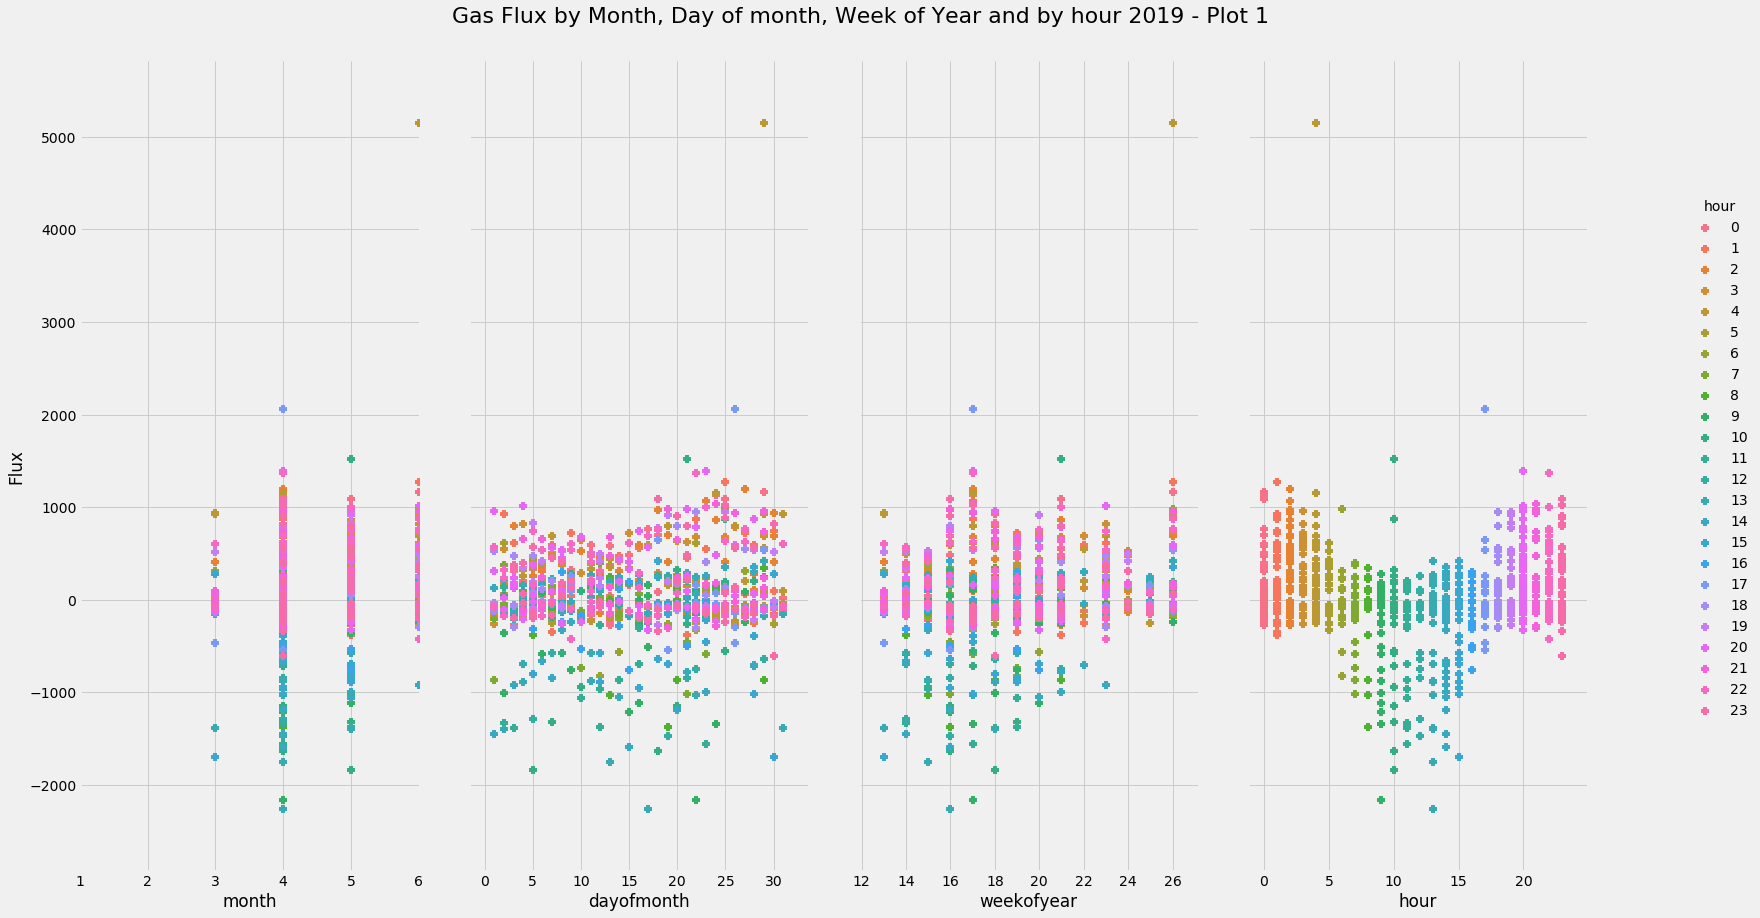

In [14]:
#plt.figure(figsize=(30,20))
sns_plot = sns.pairplot(features_target.dropna(), diag_kind="kde", markers="+", hue='hour', 
                  x_vars=['month', 'dayofmonth','weekofyear','hour'],
                  y_vars='Flux',
                      
                  plot_kws=dict(s=70, edgecolor="b", linewidth=4),
                  diag_kws=dict(shade=True))

#year_value = features_target['year'].iloc[0]      

plt.suptitle('Gas Flux by Month, Day of month, Week of Year and by hour '+str(features_target['year'].iloc[0])+' - Plot '+plotId, fontsize=22, y=1.02)

sns_plot.fig.set_figwidth(25)
sns_plot.fig.set_figheight(15)

#For plotting month
sns_plot.axes[0][0].set_xlim(1,6)
sns_plot.axes[0][0].set_ylim(None, None)

##For plotting year
#df1_year=features_target.dropna(axis=0)
## Get hold of the 'Axes' objects
#sns_plot.axes[0][0].set_xticks(df1_year['year'])
#sns_plot.axes[0][0].set_ylim(None, None)

#Save boxplot as a file
#output file name
plot_file_name="../prophetForecastPlots/Plot"+plotId+"/gasflux_Plot"+plotId+"_features.png" 
# save as png
sns_plot.savefig(plot_file_name)

plt.show()

### The second part of the code uses Prophet model to draw forecast on the historical data - for the given Plot

#### The reason to use Prophet is that:
It can be seen from the above plot (Flux Data) that there is roughly constant level (the mean of hourly flux). The seasonal fluctuation and random fluctuations roughly are constant in size over time. This suggests that it’s probably appropriate to describe the data using an additive model which is Prophet built on.

In [15]:
#Remove missing values from dataframe - drop rows where at least one value is missing
dataframe1 = dataframe.dropna()

### Split the data into training and test data set for each particular gas (CH4_dry, N2O_dry, CO2_dry)
Training data set - March till May 2019

Test data set     - June 2019 

In [16]:
#Train Test - split data
split_date = '31-May-2019'

dataf = dataframe1.dropna(axis=0)  #HERE USE DATAFRAME not features_target(this is for visualising)

dataframe_train = dataf.loc[dataf.index <= split_date].copy()
dataframe_test  = dataf.loc[dataf.index > split_date].copy()

#CH4_dry
dataframe_train_CH4dry = dataframe_train[dataframe_train['ghg'] == 'CH4_dry']
dataframe_test_CH4dry  = dataframe_test[dataframe_test['ghg'] == 'CH4_dry']

#N2O_dry
dataframe_train_N2Odry = dataframe_train[dataframe_train['ghg'] == 'N2O_dry']
dataframe_test_N2Odry  = dataframe_test[dataframe_test['ghg'] == 'N2O_dry']

#CO2_dry
dataframe_train_CO2dry = dataframe_train[dataframe_train['ghg'] == 'CO2_dry']
dataframe_test_CO2dry  = dataframe_test[dataframe_test['ghg'] == 'CO2_dry']


print(dataframe_test_CH4dry.head(10))
print(dataframe_train_CH4dry.head(10))

print(dataframe_train_N2Odry.head(10))
print(dataframe_train_N2Odry.head(10))

print(dataframe_train_CO2dry.head(10))
print(dataframe_test_CO2dry.head(10))

                         Flux      ghg
DateTime                              
2019-06-03 01:28:00 -148.8897  CH4_dry
2019-06-03 14:23:00 -144.5190  CH4_dry
2019-06-03 18:41:00  -69.0367  CH4_dry
2019-06-03 23:00:00 -197.3870  CH4_dry
2019-06-04 03:18:00  -84.3682  CH4_dry
2019-06-04 20:31:00 -204.0790  CH4_dry
2019-06-05 00:50:00   59.7503  CH4_dry
2019-06-05 05:08:00 -119.4718  CH4_dry
2019-06-05 18:03:00   77.6509  CH4_dry
2019-06-05 22:21:00 -136.4148  CH4_dry
                         Flux      ghg
DateTime                              
2019-03-26 17:26:00  -98.0130  CH4_dry
2019-03-26 21:49:00  -25.5522  CH4_dry
2019-03-27 06:28:00  -54.1259  CH4_dry
2019-03-30 02:43:00  940.7205  CH4_dry
2019-03-30 15:27:00  -59.4622  CH4_dry
2019-03-30 19:51:00  -15.6516  CH4_dry
2019-03-31 00:17:00   12.6818  CH4_dry
2019-03-31 04:43:00  -33.2795  CH4_dry
2019-03-31 13:32:00  -75.9083  CH4_dry
2019-03-31 22:22:00  -64.5129  CH4_dry
                         Flux      ghg
DateTime                 

### Visualise the training and test data sets

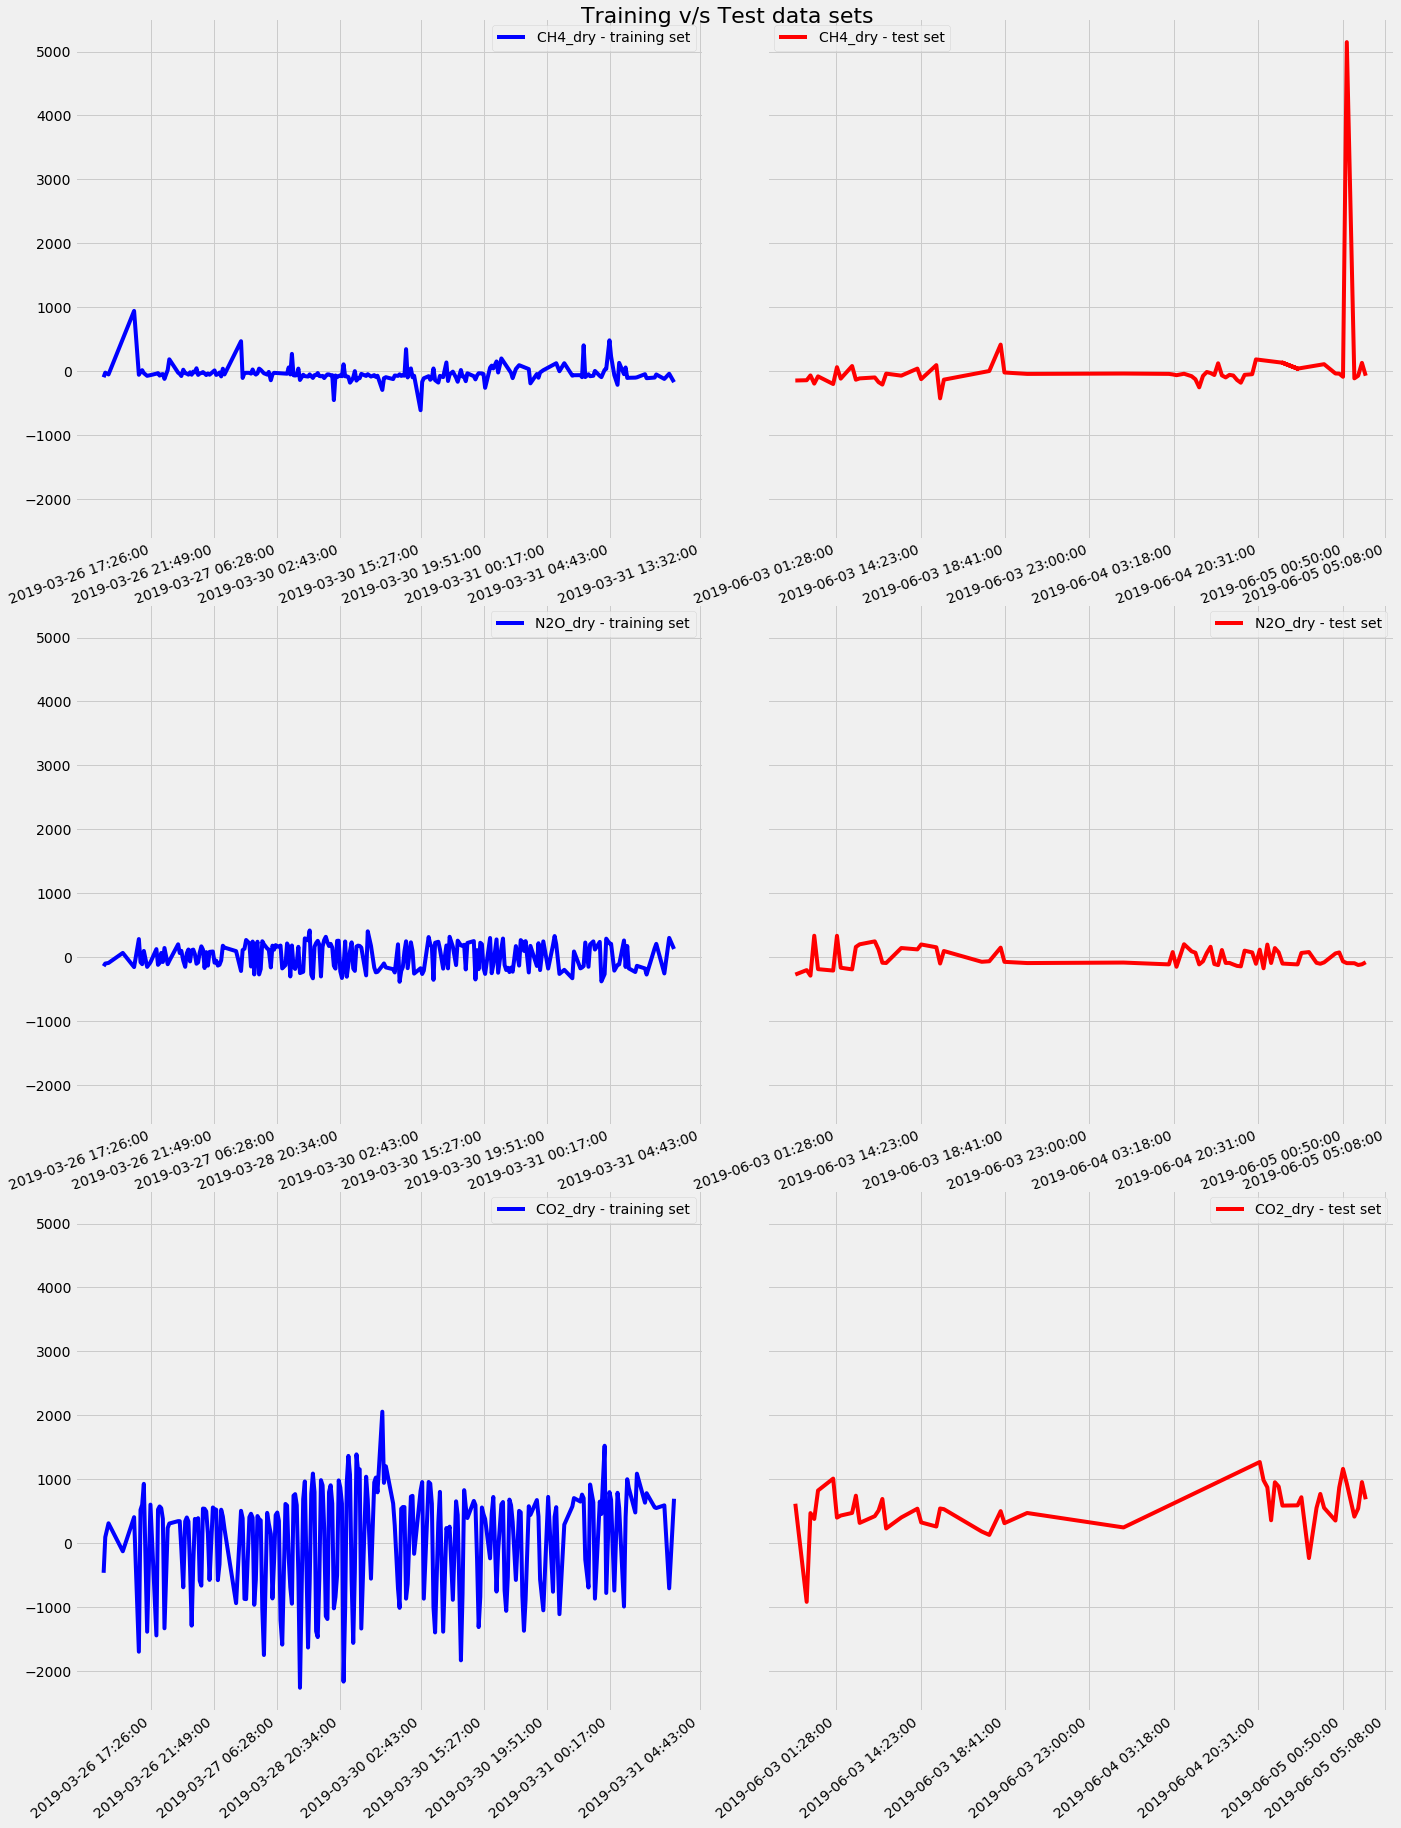

In [17]:
#Visualise the training and test data sets
fig, (axs) = plt.subplots(ncols=2, nrows=3, sharey=True, figsize=(20,25))
fig.suptitle("Training v/s Test data sets", fontsize=22)
fig.tight_layout(pad=3.0)

df_CH4dry = dataframe[dataframe['ghg'] == 'CH4_dry']

df_N2Odry = dataframe[dataframe['ghg'] == 'N2O_dry']

df_CO2dry = dataframe[dataframe['ghg'] == 'CO2_dry']

axs[0][0].plot(dataframe_train_CH4dry['Flux'], color='blue')
axs[0][0].set_xticklabels(dataframe_train_CH4dry.index, rotation=20, ha='right')

axs[0][1].plot(dataframe_test_CH4dry['Flux'], color='red')
axs[0][1].set_xticklabels(dataframe_test_CH4dry.index, rotation=20, ha='right')

axs[1][0].plot(dataframe_train_N2Odry['Flux'], color='blue')
axs[1][0].set_xticklabels(dataframe_train_N2Odry.index, rotation=20, ha='right')

axs[1][1].plot(dataframe_test_N2Odry['Flux'], color='red')
axs[1][1].set_xticklabels(dataframe_test_N2Odry.index, rotation=20, ha='right')

axs[2][0].plot(dataframe_train_CO2dry['Flux'], color='blue')
axs[2][0].set_xticklabels(dataframe_train_CO2dry.index, rotation=40, ha='right')

axs[2][1].plot(dataframe_test_CO2dry['Flux'], color='red')
axs[2][1].set_xticklabels(dataframe_test_CO2dry.index, rotation=40, ha='right')

axs[0][0].legend(['CH4_dry - training set'])
axs[0][1].legend(['CH4_dry - test set'])
axs[1][0].legend(['N2O_dry - training set'])
axs[1][1].legend(['N2O_dry - test set'])
axs[2][0].legend(['CO2_dry - training set'])
axs[2][1].legend(['CO2_dry - test set'])

plt.show()

#fig, axs = plt.subplots(3, figsize=(10,10))
#fig.suptitle('Training and Test data sets')
#axs[0].plot(dataframe_train)
#axs[1].plot(dataframe_test)

### Remove any outliers from the training datasets  - 
- seems none
- test data sets hold few outliers

### Check for any seasonal patterns in the gas flux

### Format training data for prophet model using ds and y

In [18]:
dataframe_train_CH4dry

,Flux,ghg
DateTime,,
2019-03-26 17:26:00,-98.0130,CH4_dry
2019-03-26 21:49:00,-25.5522,CH4_dry
2019-03-27 06:28:00,-54.1259,CH4_dry
2019-03-30 02:43:00,940.7205,CH4_dry
2019-03-30 15:27:00,-59.4622,CH4_dry
...,...,...
2019-05-26 23:52:00,-102.7012,CH4_dry
2019-05-27 04:10:00,-54.6238,CH4_dry
2019-05-28 01:42:00,-124.2922,CH4_dry


In [19]:
dataframe_train_CH4dry_frct = dataframe_train_CH4dry.drop('ghg', axis=1, errors='ignore')
dataframe_train_CH4dry_frct = dataframe_train_CH4dry_frct.reset_index()

dataframe_train_CH4dry_frct

,DateTime,Flux
0,2019-03-26 17:26:00,-98.0130
1,2019-03-26 21:49:00,-25.5522
2,2019-03-27 06:28:00,-54.1259
3,2019-03-30 02:43:00,940.7205
4,2019-03-30 15:27:00,-59.4622
...,...,...
208,2019-05-26 23:52:00,-102.7012
209,2019-05-27 04:10:00,-54.6238
210,2019-05-28 01:42:00,-124.2922
211,2019-05-28 14:37:00,-42.8035


#### Do the same for the test data set

In [20]:
dataframe_test_CH4dry = dataframe_test_CH4dry.drop('ghg', axis=1, errors='ignore')

dataframe_test_CH4dry

,Flux
DateTime,
2019-06-03 01:28:00,-148.8897
2019-06-03 14:23:00,-144.5190
2019-06-03 18:41:00,-69.0367
2019-06-03 23:00:00,-197.3870
2019-06-04 03:18:00,-84.3682
2019-06-04 20:31:00,-204.0790
2019-06-05 00:50:00,59.7503
2019-06-05 05:08:00,-119.4718
2019-06-05 18:03:00,77.6509


In [21]:
# Format training data for prophet model using ds and y
#dataframe_train_CH4dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'}).head()

dataframe_train_CH4dry_frct = dataframe_train_CH4dry_frct.rename(columns={'DateTime': 'ds', 'Flux': 'y'}).head()
dataframe_train_CH4dry_frct

,ds,y
0,2019-03-26 17:26:00,-98.0130
1,2019-03-26 21:49:00,-25.5522
2,2019-03-27 06:28:00,-54.1259
3,2019-03-30 02:43:00,940.7205
4,2019-03-30 15:27:00,-59.4622


## Forecasting CH4_dry 

#### Display the distribution of the CH4_dry gas flux  

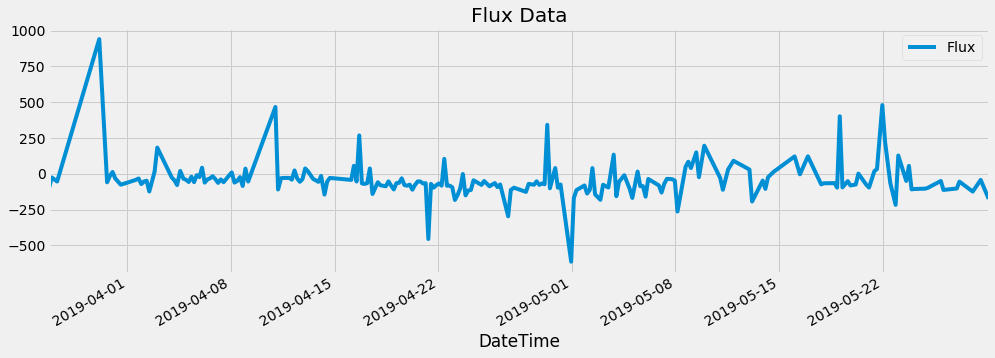

In [22]:
dataframe_train_CH4dry.plot(style='-', figsize=(15,5), title='Flux Data')

### ### Visualising gas flux per time

In [23]:
#Choose one particular gas
#Choose one day from the dataset
dataframe_train_CH4dry_hourly = dataframe_train_CH4dry.copy()
#print(dataframe_train_CH4dry_hourly)

df         = DataFrame()
df['date'] = pd.to_datetime(dataframe_train_CH4dry_hourly.index)  
#print(df['date'])

start_date = '2019-04-25'
end_date   = '2019-04-26'
#mask = (df['date'] >= start_date) & (df['date'] < end_date)
#print(mask)

df1 = dataframe_train_CH4dry_hourly[((dataframe_train_CH4dry_hourly.index >= start_date) & (dataframe_train_CH4dry_hourly.index < end_date))]
                                    
print(df1)

                        Flux      ghg
DateTime                             
2019-04-25 02:14:00 -50.4359  CH4_dry
2019-04-25 10:51:00 -87.1687  CH4_dry
2019-04-25 19:35:00 -64.8988  CH4_dry
2019-04-25 23:53:00 -93.0514  CH4_dry


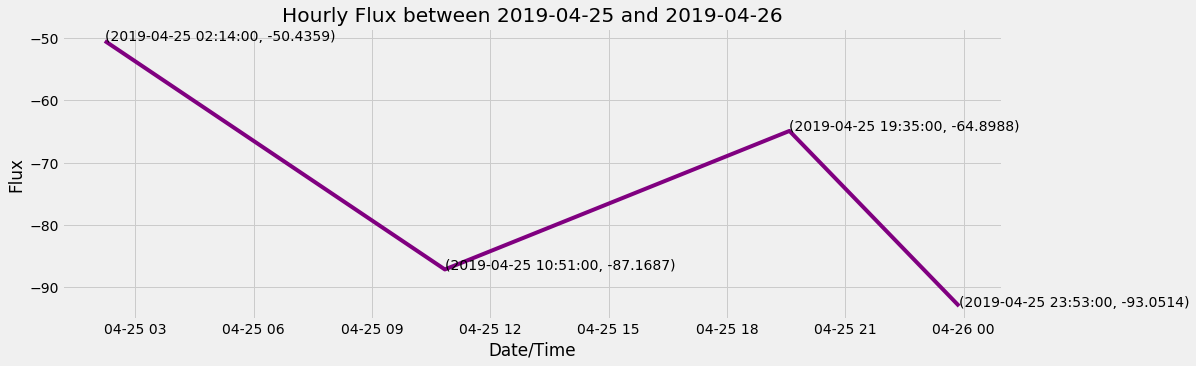

In [24]:
# Create figure and plot space
df2 = df1.reset_index()

fig, ax = plt.subplots(figsize=(15, 5))

# Add x-axis and y-axis
ax.plot(df2['DateTime'],
        df2['Flux'],
        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date/Time",
       ylabel="Flux",
       title="Hourly Flux between "+start_date+" and "+end_date)

#plt.plot(A,B)
for xy in zip(df2['DateTime'], df2['Flux']):                                     
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data') 


#plt.grid()   
plt.show()

##### Note: There is an increase in the evening

### Visualising gas flux per day

In [25]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

#Get a slice of features_target and merge with dataframe_train_CH4dry
df_dayofweek = features_target['dayofweek']

#Merge with dataframe_train_CH4dry
dataframe_train_CH4dry_dayofweek = pd.merge(df_dayofweek, dataframe_train_CH4dry, on='DateTime')


for index, row in dataframe_train_CH4dry_dayofweek.iterrows():
    #day_num = dataframe_train_CH4dry_dayofweek['dayofweek']
    #dataframe_train_CH4dry_dayofweek['dayname'] = days[day_num]
    #print(index, row.dayofweek, '\n')
    
    row.dayofweek = days[row.dayofweek]
    #print(index, row.dayofweek, '\n')
    #dataframe_train_CH4dry_dayofweek.iloc[index, ['dayofweek'] = row.dayofweek
    dataframe_train_CH4dry_dayofweek.loc[index, 'dayofweek'] = row.dayofweek

    
dataframe_train_CH4dry_dayofweek.reset_index(drop=True, inplace=True)
dataframe_train_CH4dry_dayofweek = dataframe_train_CH4dry_dayofweek.drop('ghg', axis=1)
dataframe_train_CH4dry_dayofweek

,dayofweek,Flux
0,Tuesday,-98.0130
1,Tuesday,-98.0130
2,Tuesday,-98.0130
3,Tuesday,-25.5522
4,Tuesday,-25.5522
...,...,...
634,Tuesday,-42.8035
635,Tuesday,-42.8035
636,Wednesday,-174.8337
637,Wednesday,-174.8337


In [26]:
#sns.set(style="whitegrid")
##tips = sns.load_dataset("dataframe_train_CH4dry_dayofweek")
#ax = sns.barplot(x="dayofweek", y="Flux", data=dataframe_train_CH4dry_dayofweek)

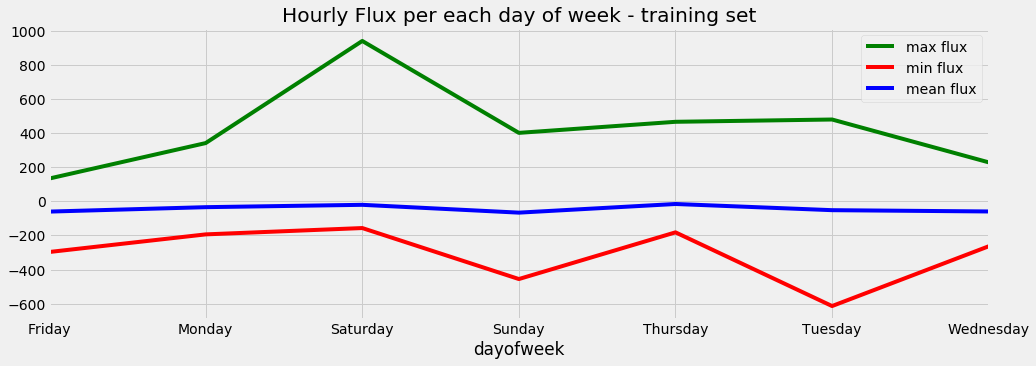

In [27]:
#Plot the training dataset
fig, ax = plt.subplots(figsize=(15, 5))

ax = plt.gca()

df = dataframe_train_CH4dry_dayofweek
#print(df.groupby('dayofweek').sum())
df.groupby('dayofweek').max().plot(kind='line', ax=ax, color='green')
df.groupby('dayofweek').min().plot(kind='line', ax=ax, color='red')
df.groupby('dayofweek').mean().plot(kind='line', ax=ax, color='blue')
ax.legend(["max flux", "min flux", "mean flux"])
ax.title.set_text("Hourly Flux per each day of week - training set")
plt.show()

##### Note: Maximum flux in training data set = 1000

In [28]:
# Add x-axis and y-axis
#ax.plot(str(dataframe_train_CH4dry_dayofweek['dayofweek']),
#        dataframe_train_CH4dry_dayofweek['Flux'],
#        color='purple')

# Set title and labels for axes
#ax.set(xlabel="Day of week",
#       ylabel="Flux",
#       title="Hourly Flux per each day of week")

#x = str(dataframe_train_CH4dry_dayofweek['dayofweek'])
#y = dataframe_train_CH4dry_dayofweek['Flux']

#plt.plot(x, y)

### Use Prophet model without any parameters to predict on test set

#### Plot the forecast without any parameters

In [ ]:
# Setup and train model with parameters
model_nopara = Prophet() 
#model.add_seasonality(name='hourly', period=24, fourier_order=5)

#Fit the model with the training data set
model_nopara.fit(dataframe_train_CH4dry_frct)

# Predict on training set with model
forecast = model_nopara.predict(df=dataframe_test_CH4dry.reset_index().rename(columns={'DateTime': 'ds'}))

forecast.head()

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model_nopara.plot(forecast,ax=ax)
plt.show()

In [35]:
dataframe_train_CH4dry_frct


,ds,y
0,2019-03-26 17:26:00,-98.0130
1,2019-03-26 21:49:00,-25.5522
2,2019-03-27 06:28:00,-54.1259
3,2019-03-30 02:43:00,940.7205
4,2019-03-30 15:27:00,-59.4622


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


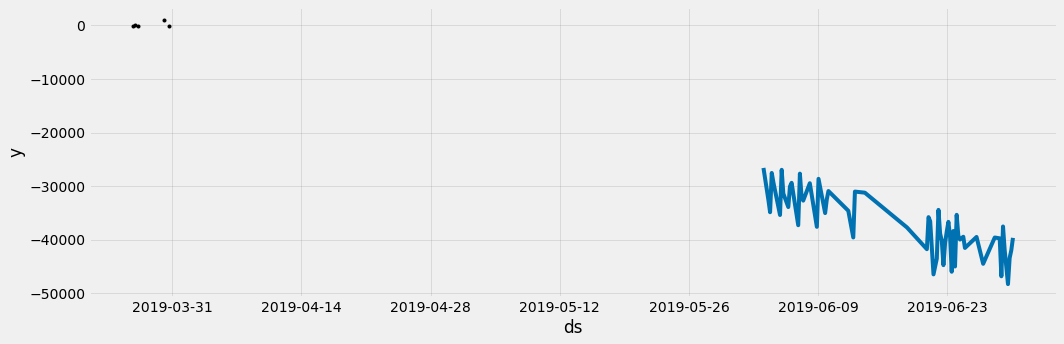

In [32]:
# Setup and train model and fit
model1 = Prophet()
model1.fit(dataframe_train_CH4dry_frct)
dataframe_test_frct = model1.predict(df=dataframe_test_CH4dry.reset_index().rename(columns={'DateTime': 'ds'}))

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model1.plot(dataframe_test_frct,ax=ax)
plt.show()

In [ ]:
fig      = model.plot_components(forecast)

##### Note: There is a dip at noon, there is an increase in the afternoon.

### Use Prophet model with any parameters to predict on test set¶

In [193]:
dataframe_train_CH4dry_frct

,ds,y
0,2019-03-26 17:26:00,-98.0130
1,2019-03-26 21:49:00,-25.5522
2,2019-03-27 06:28:00,-54.1259
3,2019-03-30 02:43:00,940.7205
4,2019-03-30 15:27:00,-59.4622


In [187]:
print("train min")
print(dataframe_train_CH4dry_frct[dataframe_train_CH4dry_frct['y'] == dataframe_train_CH4dry_frct['y'].min()])

print("train max")
print(dataframe_train_CH4dry_frct[dataframe_train_CH4dry_frct['y'] == dataframe_train_CH4dry_frct['y'].max()])

print("test min")
print(dataframe_test_CH4dry[dataframe_test_CH4dry['Flux'] == dataframe_test_CH4dry['Flux'].min()])

print("test max")
print(dataframe_test_CH4dry[dataframe_test_CH4dry['Flux'] == dataframe_test_CH4dry['Flux'].max()])


train min
                   ds       y
0 2019-03-26 17:26:00 -98.013
train max
                   ds         y
3 2019-03-30 02:43:00  940.7205
test min
                         Flux
DateTime                     
2019-06-09 22:09:00 -428.0267
test max
                          Flux
DateTime                      
2019-06-29 04:46:00  5148.4019


In [190]:
#future = dataframe_test_CH4dry.reset_index().rename(columns={'DateTime': 'ds'})
#future['cap'] = 5000
#future['floor'] = -5000

#dataframe_train_CH4dry_frct_v1 = dataframe_train_CH4dry_frct.copy()
#dataframe_train_CH4dry_frct_v1['cap']   = 5000
#dataframe_train_CH4dry_frct_v1['floor'] = -5000

# Setup and train model with parameters
model = Prophet(interval_width=0.95, yearly_seasonality=False, weekly_seasonality=True)
#, changepoint_prior_scale=0.5
#model.add_seasonality(name='hourly', period=24, fourier_order=5)

#Fit the model with the training data set
model.fit(dataframe_train_CH4dry_frct)

# Predict on training set with model
forecast = model.predict(df=dataframe_test_CH4dry.reset_index().rename(columns={'DateTime': 'ds'}))

#future_dates = my_model.make_future_dataframe(periods=3, freq='D')

INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


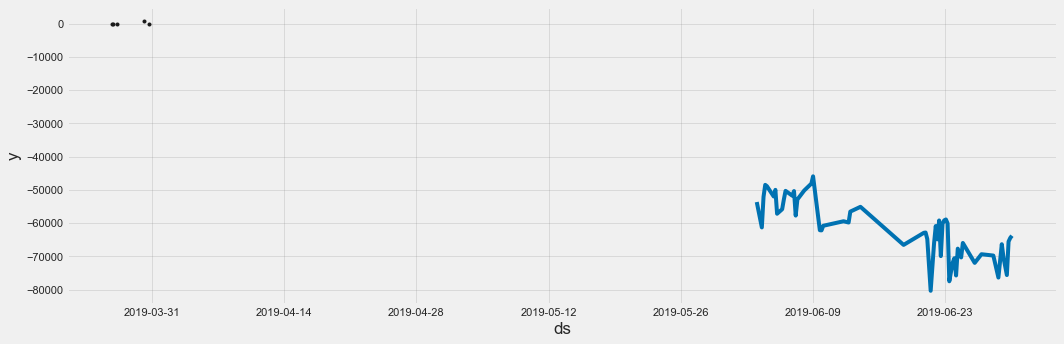

In [194]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

In [ ]:
fig      = model.plot_components(forecast)

### Compare the predicted data against the test set

In [76]:
dataframe_test_CH4dry_dayofweek

,dayofweek,Flux
DateTime,,
2019-06-03 01:28:00,0,-148.8897
2019-06-03 01:28:00,0,-148.8897
2019-06-03 01:28:00,0,-148.8897
2019-06-03 14:23:00,0,-144.5190
2019-06-03 14:23:00,0,-144.5190
...,...,...
2019-06-29 21:59:00,5,127.2111
2019-06-29 21:59:00,5,127.2111
2019-06-30 02:17:00,6,-74.0129


In [167]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

seriesObj = features_target['dayofweek']

df1 = seriesObj.to_frame()

#Merge with test dataframe
df2 = dataframe_test_CH4dry.copy()

df_merge_col = pd.merge(df1, df2, on='DateTime')


df_merge_col

for index, row in df_merge_col.iterrows():
    row.dayofweek = days[int(row.dayofweek)]  #convert datetime object to string
    df_merge_col.loc[index, 'dayofweek'] = row.dayofweek
    #print(index, row.dayofweek, '\n')

df_merge_col.reset_index(drop=True, inplace=True)
df_merge_col

,dayofweek,Flux
0,Monday,-148.8897
1,Monday,-148.8897
2,Monday,-148.8897
3,Monday,-144.5190
4,Monday,-144.5190
...,...,...
162,Saturday,127.2111
163,Saturday,127.2111
164,Sunday,-74.0129
165,Sunday,-74.0129


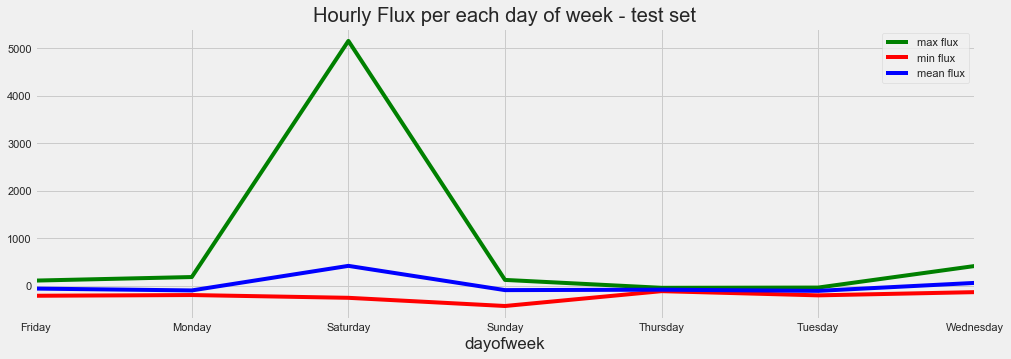

In [168]:
#Plot the test set

fig, ax = plt.subplots(figsize=(15, 5))

ax = plt.gca()

df = df_merge_col
#print(df.groupby('dayofweek').sum())
df.groupby('dayofweek').max().plot(kind='line', ax=ax, color='green')
df.groupby('dayofweek').min().plot(kind='line', ax=ax, color='red')
df.groupby('dayofweek').mean().plot(kind='line', ax=ax, color='blue')
ax.legend(["max flux", "min flux", "mean flux"])
ax.title.set_text("Hourly Flux per each day of week - test set")
plt.show()

### Add parameters to make the result more accurate

### Do forecast - hourly and daily (for 2 weeks)

In [322]:
# Predict on training set with model
dataframe_test_frct = model.predict(df=dataframe_test.reset_index().rename(columns={'DateTime': 'ds'}))

In [323]:
dataframe_test_frct.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-03 01:28:00,-15.417548,-339.316546,753.398032,-15.432608,-15.403587,201.518621,201.518621,201.518621,223.600874,223.600874,223.600874,-22.082253,-22.082253,-22.082253,0.0,0.0,0.0,186.101073
1,2019-06-03 01:28:00,-15.417548,-390.435931,770.903103,-15.432608,-15.403587,201.518621,201.518621,201.518621,223.600874,223.600874,223.600874,-22.082253,-22.082253,-22.082253,0.0,0.0,0.0,186.101073
2,2019-06-03 01:28:00,-15.417548,-337.377190,766.501310,-15.432608,-15.403587,201.518621,201.518621,201.518621,223.600874,223.600874,223.600874,-22.082253,-22.082253,-22.082253,0.0,0.0,0.0,186.101073
3,2019-06-03 14:23:00,-15.285007,-843.628901,233.909165,-15.302905,-15.268250,-311.593488,-311.593488,-311.593488,-306.312666,-306.312666,-306.312666,-5.280823,-5.280823,-5.280823,0.0,0.0,0.0,-326.878496
4,2019-06-03 14:23:00,-15.285007,-866.085092,228.904272,-15.302905,-15.268250,-311.593488,-311.593488,-311.593488,-306.312666,-306.312666,-306.312666,-5.280823,-5.280823,-5.280823,0.0,0.0,0.0,-326.878496


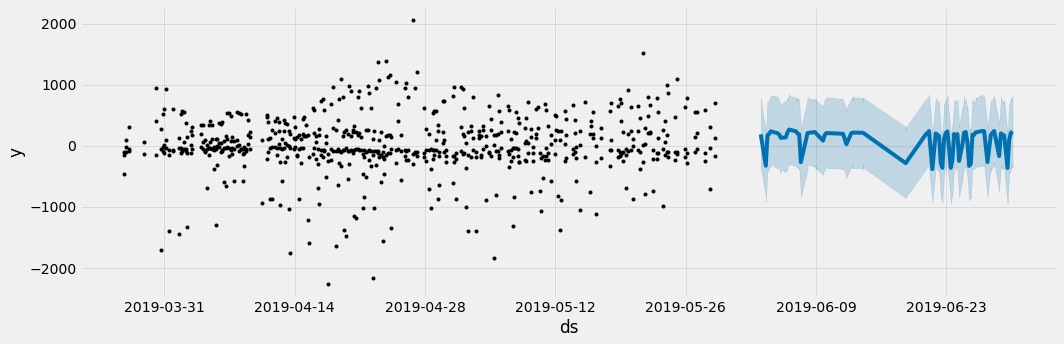

In [324]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(dataframe_test_frct,ax=ax)
plt.show()

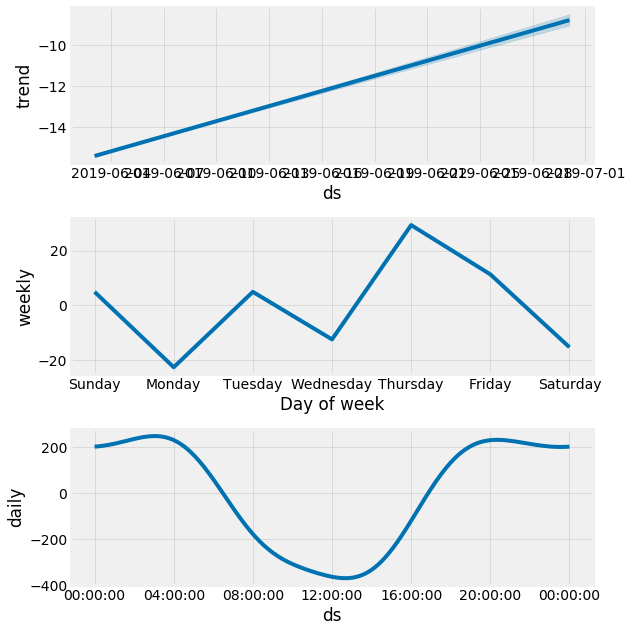

In [261]:
# Plot the components of the model
fig = model.plot_components(dataframe_test_frct)

Compare Forecast to Actual

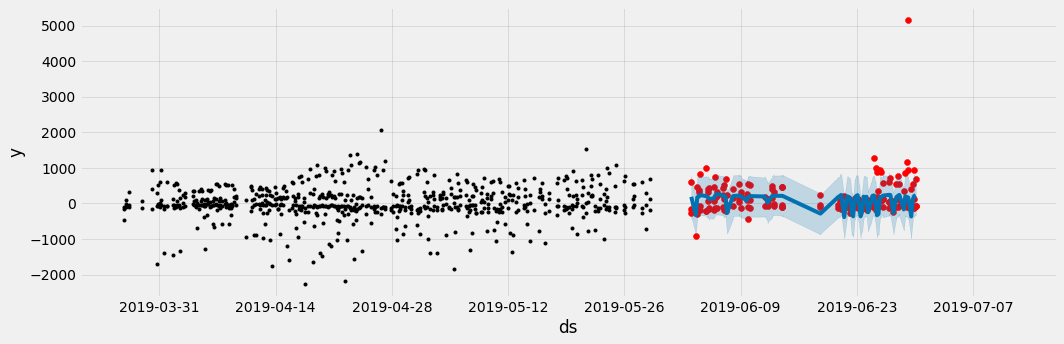

In [262]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test.index, dataframe_test['Flux'], color='r')
fig = model.plot(dataframe_test_frct, ax=ax)

Look at first month of predictions

In [263]:
dataframe_test.head(5)
dataframe_test.dtypes

Flux    float64
dtype: object

In [ ]:
# Plot the forecast with the actuals
#f, ax = plt.subplots(1)
#f.set_figheight(5)
#f.set_figwidth(15)
#ax.scatter(dataframe_test.index, dataframe_test['Flux'], color='r')
#fig = model.plot(dataframe_test_frct, ax=ax)
#ax.set_xbound(lower='01-01-2019',
#              upper='02-01-2019')

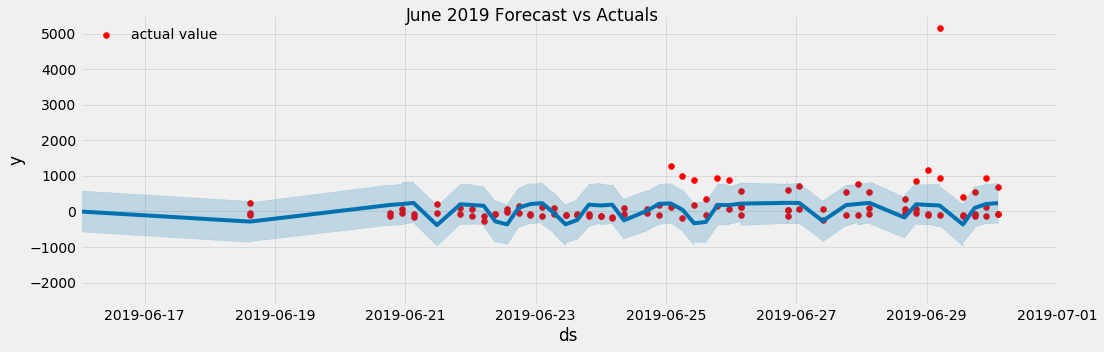

In [275]:
# Plot the forecast with the actuals   - for month of June predictions

#from_date = 201961
#to_date   = 2019301
#date_f = datetime.fromtimestamp(from_date / 1e3)
#date_t = datetime.fromtimestamp(to_date / 1e3)

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test.index, dataframe_test['Flux'], color='r', label='actual value')
fig = model.plot(dataframe_test_frct, ax=ax)
ax.legend(loc='upper left', frameon=False)

#set limits
ax.set_xlim([datetime.date(2019, 6, 16), datetime.date(2019, 7, 1)])
#ax.set_xbound(lower='01-Jun-2019', upper='30-Jun-2019')             - this line does not work
#ax.set_ylim(0, 60000)
plot = plt.suptitle('June 2019 Forecast vs Actuals')

#Save boxplot as a file
#output file name
plot_file_name="./prophetPlots/Plot1/gasflux_June_forecast_actual.png" 
# save as png
plt.savefig(plot_file_name)

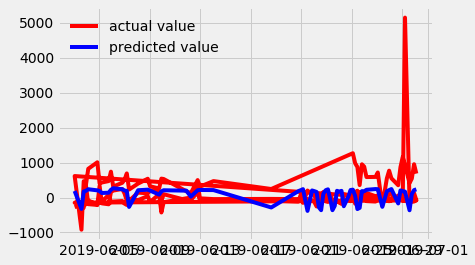

In [286]:
#Stacking subplots  - Another way to visualise the above plot using matplotlib only
#fig, axs = plt.subplots(2)
#fig.suptitle('Vertically stacked subplots')
plt.plot(dataframe_test.index, dataframe_test['Flux'], color='r', label='actual value')
plt.plot(dataframe_test_frct['ds'], dataframe_test_frct['yhat'], color='b', label='predicted value')
plt.legend(loc='upper left', frameon=False)

In [ ]:
 #Plot the forecast with the actuals   - for month of July predictions  - JUST FOR TESTING PURPOSE - 
 # Note the model predicts outputs that exist; if we want to predict for values that do not exist, then use forecast

#from_date = 201961
#to_date   = 2019301
#date_f = datetime.fromtimestamp(from_date / 1e3)
#date_t = datetime.fromtimestamp(to_date / 1e3)

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test.index, dataframe_test['Flux'], color='r', label='actual value')
fig = model.plot(dataframe_test_frct, ax=ax)
ax.legend(loc='upper left', frameon=False)

#set limits
ax.set_xlim([datetime.date(2019, 7, 1), datetime.date(2019, 8, 1)])
#ax.set_xbound(lower='01-Jun-2019', upper='30-Jun-2019')             - this line does not work
#ax.set_ylim(0, 60000)
plot = plt.suptitle('June 2019 Forecast vs Actuals')

#Save boxplot as a file
#output file name
plot_file_name="./prophetPlots/Plot1/gasflux_July_forecast_actual.png" 
# save as png
plt.savefig(plot_file_name)

Drawing single week of predictions

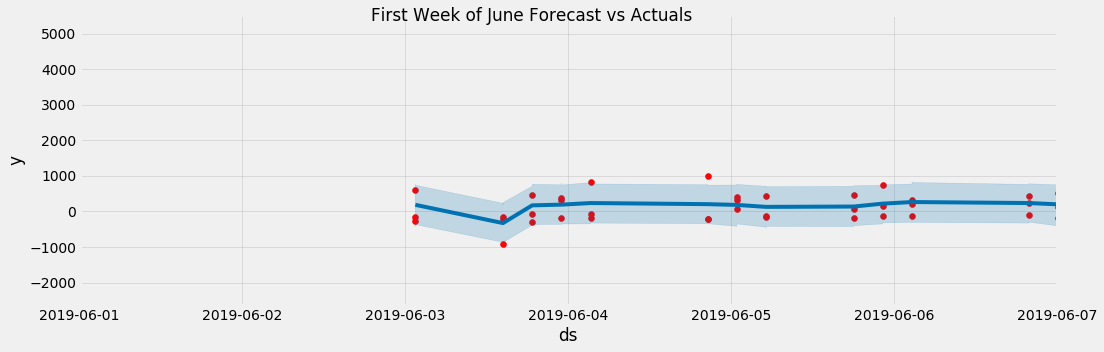

In [289]:
#Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test.index, dataframe_test['Flux'], color='r')
fig = model.plot(dataframe_test_frct, ax=ax)
ax.set_xlim([datetime.date(2019, 6, 1), datetime.date(2019, 6, 7)])
plot = plt.suptitle('First Week of June Forecast vs Actuals')

#Error Metrics

In [292]:
mean_squared_error(y_true=dataframe_test['Flux'],y_pred=dataframe_test_frct['yhat'])

262378.98158038524

In [293]:
mean_absolute_error(y_true=dataframe_test['Flux'],y_pred=dataframe_test_frct['yhat'])

314.1198464368257

In [297]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=dataframe_test['Flux'],y_pred=dataframe_test_frct['yhat'])

674.0756132704348

The above can be continued to compare the test set against the predicted test set

In [41]:
#Time Series Forecasting using Prophet
# set the uncertainty interval to 95% (the Prophet default is 80%)
#‘interval_width=0.95’, this sets the uncertainty interval to produce a confidence interval around the forecast.
#my_model = Prophet(interval_width=0.95)

##### We need to plot data - daily basis. And also plot daily mean for each plot  - Resampling

In [ ]:
#Plotting for one day
#Extract only datetime and flux from the series
'''
dataX = read_excel('plotData_1.xlsx', sheet_name='Plot1_FluxData', index_col=13, parse_dates=[0]) #read excel into a dataframe

dataframeX = DataFrame()
#dataframe['DateTime'] = data['DateTime']
dataframeX['Flux']     = dataX['flux']


#Plot the data
#pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
dataframeX.plot(style='--', figsize=(15,5), title='Flux Data')
plt.show()
'''

Forecasting Version 1 - Use Prophet without any parameters

In [307]:
model_v1 = Prophet(interval_width=0.95)   #by default is 80%
                                        #interval_width sets the uncertainty interval to produce a confidence interval around the forecast

In [308]:
#rename the columns and save them to a new dataframe to be used in the Prophet model
df_train = dataframe_train.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})
print(df_train.head(10))

                   ds         y
0 2019-03-26 17:26:00 -144.0262
1 2019-03-26 21:49:00 -102.3469
2 2019-03-27 06:28:00  -93.0909
3 2019-03-28 20:34:00   63.8219
4 2019-03-30 02:43:00 -157.9453
5 2019-03-30 15:27:00  280.6187
6 2019-03-30 19:51:00  -81.8122
7 2019-03-31 00:17:00 -112.4232
8 2019-03-31 04:43:00   94.8818
9 2019-03-31 13:32:00 -154.8489


In [309]:
model_v1.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [312]:
#Make forecast for the next 30 days (i.e month of June)
future_dates = model_v1.make_future_dataframe(periods=30, freq='d')
future_dates.tail()

,ds
702,2019-06-24 03:33:00
703,2019-06-25 03:33:00
704,2019-06-26 03:33:00
705,2019-06-27 03:33:00
706,2019-06-28 03:33:00


In [316]:
#Predict using the dataframe future_dates
forecast = model_v1.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
702,2019-06-24 03:33:00,212.049765,-667.692626,1077.999872
703,2019-06-25 03:33:00,238.017020,-605.346177,1126.123404
704,2019-06-26 03:33:00,221.372595,-631.799338,1117.592594
705,2019-06-27 03:33:00,268.783760,-546.940235,1147.229835
706,2019-06-28 03:33:00,234.871580,-590.128449,1080.392053


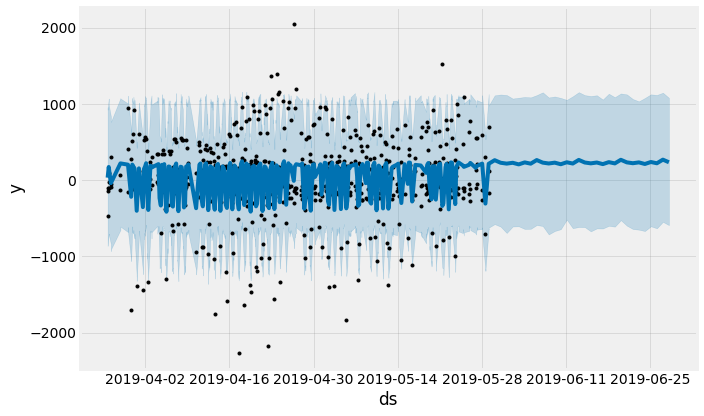

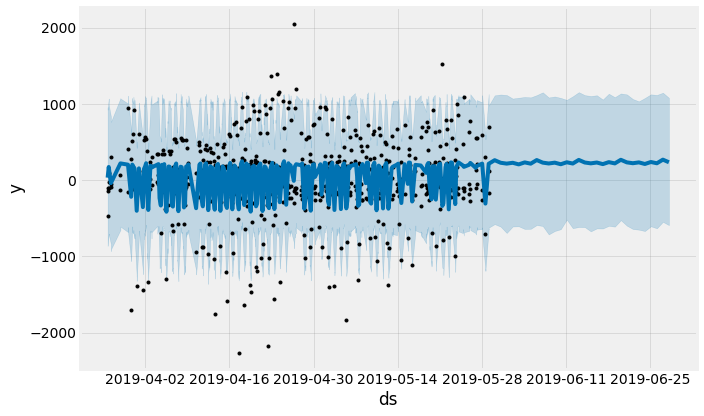

In [317]:
#Plot the results of the forecast
model_v1.plot(forecast, uncertainty=True)

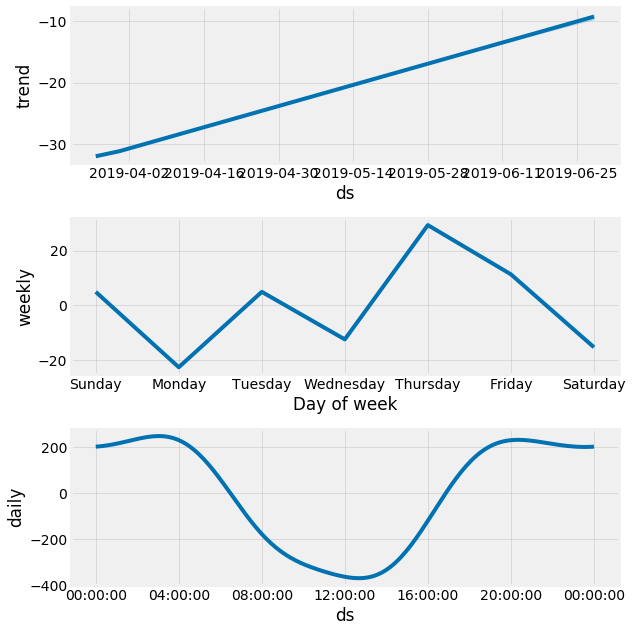

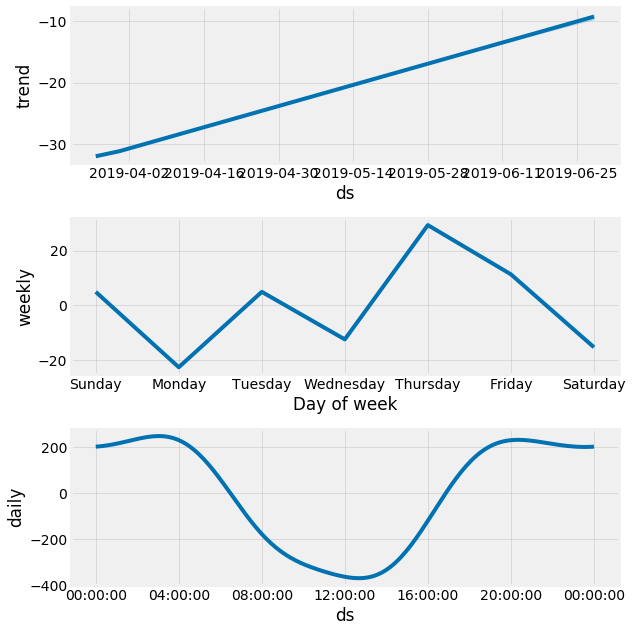

In [318]:
#Plot the components of the forecast -
# This can reveal how daily, weekly and yearly patterns of the time series can contribute to the overall forecasted values
model_v1.plot_components(forecast)

In [ ]:
#Testing
#Make forecast for the next 30 days (i.e month of June)
#future_datesTest = model_v1.make_future_dataframe(periods=36, freq='MS')
#forecastTest = model_v1.predict(future_datesTest)
#model_v1.plot(forecastTest, uncertainty=True)
#model_v1.plot_components(forecastTest)

Forecasting Version 2 - Use Prophet with seasonality, changepoint_prior parameters

In [329]:
# set the seasonality - to daily, weekly, 
# forecast on monthly

model_v2 = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=2)
model_v2.add_seasonality(name='monthly', period=30, fourier_order=5, prior_scale=0.02)

In [330]:
#Fit the model with training data
model_v2.fit(df_train)

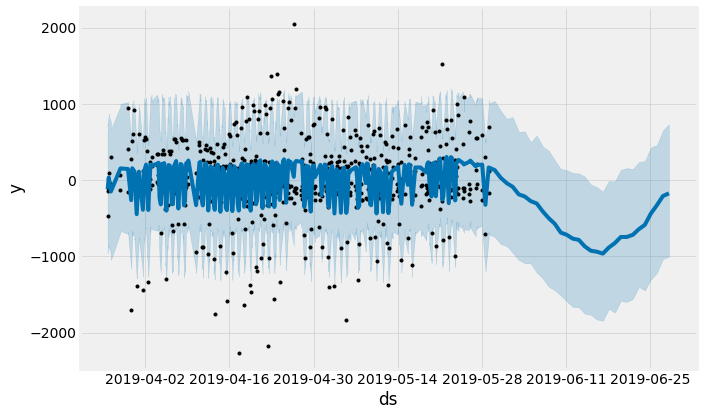

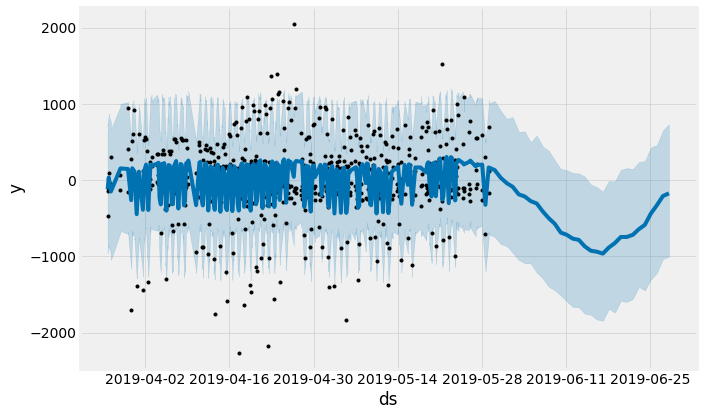

In [331]:
future_dates_v2 = model_v2.make_future_dataframe(periods=30, freq='d')
forecast_v2     = model_v2.predict(future_dates_v2)
model_v2.plot(forecast_v2, uncertainty=True)

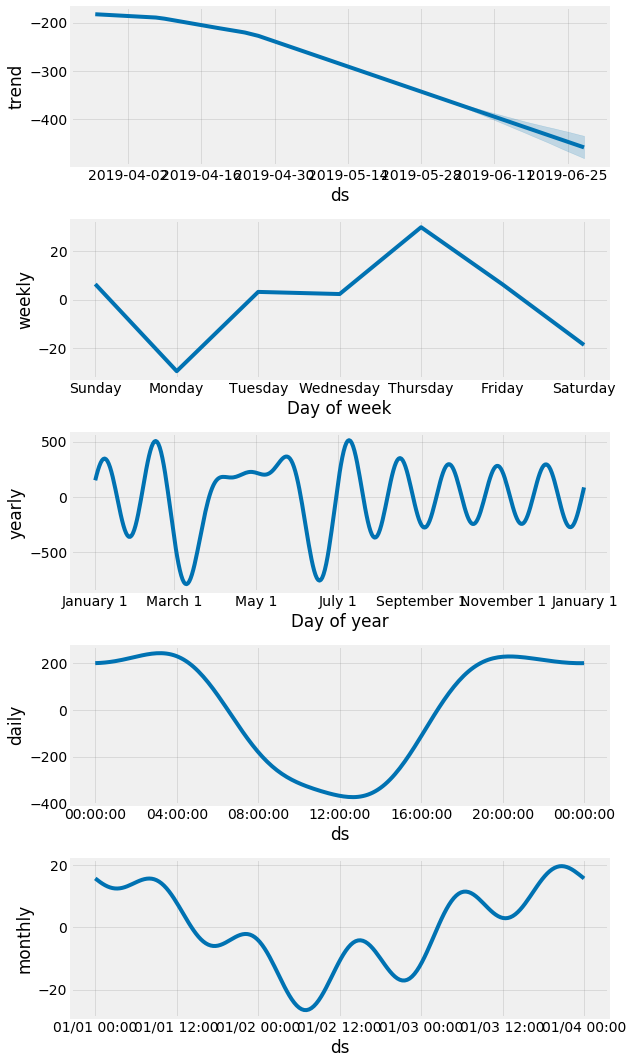

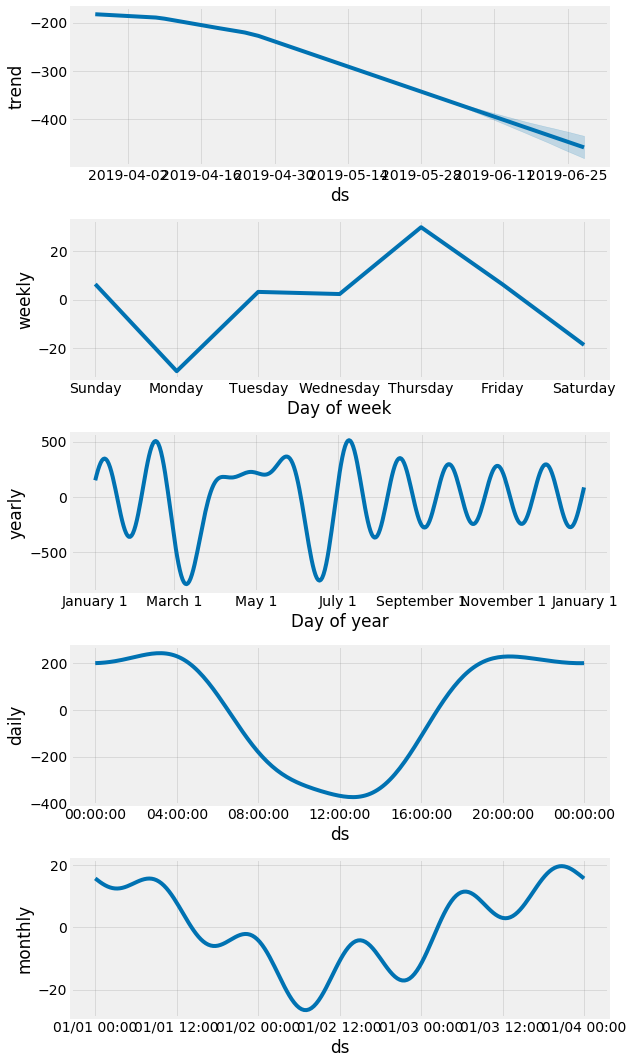

In [328]:
#Plot the components
model_v2.plot_components(forecast_v2)